In [312]:
# Kontroles bloks
# ================================
TRAIN = True

# Norādam apmācīta modeļa ielādes URL.
#MODEL_LABEL_URL = "https://dl.dropbox.com/scl/fi/dbfmom97uthtz9loxyhai/li-na-petrova-lp23082-graphic.ipynb?rlkey=2gf4nmaq6xcu4jjyxm6l51p3h&st=gvul2smh&dl=1"

# Norādam ceļus uz treniņa un validācijas datu CSV failiem 

TRAIN_DATA_URL = "https://dl.dropbox.com/scl/fi/m2nlorjdrscxtnjzsddhe/Iris_train.csv?rlkey=kz6fx09q93gtewhwe156n119c&st=pxsx228c&dl=1"
TEST_DATA_URL  = "https://dl.dropbox.com/scl/fi/77leobgukmkya8x97rqep/Iris_validate.csv?rlkey=0kz2ic3m37wsld39o5cufhff0&st=mb0fe55m&dl=1"

print(TEST_DATA_URL)

https://dl.dropbox.com/scl/fi/77leobgukmkya8x97rqep/Iris_validate.csv?rlkey=0kz2ic3m37wsld39o5cufhff0&st=mb0fe55m&dl=1


In [313]:
# Moduļu importēšana
# ================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

import seaborn as sns
import pickle

import warnings
warnings.filterwarnings("ignore")

In [314]:
# Klases un funkciju definēšana
# ================================
# Šeit definējam:
#  - Minimālo lineāro modeli, kā vienkāršo lineāro transformācija no 4 ieejām uz 3 izejām
#  - TrainIrisModel() funkciju neirontīkla apmācībai
#  - TestIrisModel() funkciju neirontīkla modeļa testēšanai
#  - SaveWeights() un Loadweights() funkcijas izveidošana svaru saglabāšanai un ielādēšanai


class MinimalLinearModel(nn.Module):
    def __init__(self, input_dim=4, output_dim=3):
        super(MinimalLinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

model = MinimalLinearModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

scaler = None
le = None

def TrainIrisModel(data_df):
    """
    Funkcija, kas apmāca modeli, izmantojot padoto DataFrame.
    """
    global model, criterion, optimizer, scaler, le
    print("Sākam mācību procesu...")

    # Sagatavojam datus
    X = data_df[['Kapsulu garums Cm','Kapsulu platums Cm','Ziedlapu garums Cm','Ziedlapu platums Cm']].values.astype(np.float32)
    y = data_df['Suga'].values

    # Pārveidojam klases (y) par skaitliskiem indeksiem
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Standartizējam pazīmes
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataset)
        if (epoch+1) % 2 == 0:
            print(f"Epoka {epoch+1}/{epochs}, zaudējumi: {epoch_loss:.4f}")

def TestIrisModel(data_df, num_rows=17):
    """
    Funkcija, kas testē modeli uz dotā DataFrame un izdrukā prognozes.
    """
    global model, scaler, le
    print("Sākam modeļa testēšanu...")

    if (scaler is None) or (le is None):
        print("scaler vai LabelEncoder nav ielādēti. Vispirms apmāciet modeli vai ielādējiet svarus.")
        return

    X = data_df[['Kapsulu garums Cm','Kapsulu platums Cm','Ziedlapu garums Cm','Ziedlapu platums Cm']].values.astype(np.float32)
    y = data_df['Suga'].values

    try:
        y_numeric = le.transform(y)
    except Exception as e:
        print("Kļūda klases pārveidē. Iespējams, ir jaunas klases.")
        y_numeric = None

    X_scaled = scaler.transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted_numeric = torch.max(outputs, 1)

    predicted_labels = le.inverse_transform(predicted_numeric.numpy())

    total_samples = len(data_df)
    rows_to_print = min(num_rows, total_samples)
    correct_count = 0

    for i in range(rows_to_print):
        real_label = y[i]
        pred_label = predicted_labels[i]
        is_correct = (real_label == pred_label)
        if is_correct:
            correct_count += 1
        print(f"{i+1}. Prognoze: {pred_label}; Patiesā klase: {real_label} - {'pareizi' if is_correct else 'nepareizi'}")
    
    accuracy = correct_count / rows_to_print if rows_to_print > 0 else 0
    print(f"Precizitāte: {accuracy * 100:.2f}% ({correct_count}/{rows_to_print})")

def SaveWeights():
    """
    Funkcija, kas saglabā modeļa svarus, scaler un LabelEncoder.
    """
    global model, scaler, le
    print("Saglabājam modeļa svarus un pārveides objektus...")
    torch.save(model.state_dict(), "model_weights.pth")
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(le, f)
    print("Saglabāšana pabeigta.")

def LoadWeights():
    """
    Funkcija, kas ielādē modeļa svarus, scaler un LabelEncoder.
    """
    global model, scaler, le
    print("Ielādējam modeļa svarus un pārveides objektus...")
    model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", map_location=torch.device('cpu')))
    with open("/kaggle/working/scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    with open("/kaggle/working/label_encoder.pkl", "rb") as f:
        le = pickle.load(f)
    print("Ielāde pabeigta.")



In [315]:
if TRAIN:
    # 1. Ielādējam apmācības datus
    print("Ielādējam treniņa datu kopu...")
    data_df = pd.read_csv(TRAIN_DATA_URL)

    # 2. Pārsaucam kolonnas pirms TrainIrisModel
    data_df.rename(columns={
        'SepalLengthCm': 'Kapsulu garums Cm',
        'SepalWidthCm':  'Kapsulu platums Cm',
        'PetalLengthCm': 'Ziedlapu garums Cm',
        'PetalWidthCm':  'Ziedlapu platums Cm',
        'Species':       'Suga'
    }, inplace=True)

    # 3. Apmācām modeli
    TrainIrisModel(data_df)
    # 4. Saglabājam svarus
    SaveWeights()
    
else:
    # 1. Ielādējam validācijas datus
    print("Ielādējam validācijas datu kopu...")
    data_df = pd.read_csv(TEST_DATA_URL)

    # 2. Pārsaucam kolonnas pirms TestIrisModel
    data_df.rename(columns={
        'SepalLengthCm': 'Kapsulu garums Cm',
        'SepalWidthCm':  'Kapsulu platums Cm',
        'PetalLengthCm': 'Ziedlapu garums Cm',
        'PetalWidthCm':  'Ziedlapu platums Cm',
        'Species':       'Suga'
    }, inplace=True)

    # 3. Ielādējam svarus
    LoadWeights()

# Piemērs testēšanai ar 12 nejaušām rindām
sample_df = data_df.sample(n=12, random_state=127)
print("n/Nejauši atlasīti 12 piemēri testēšanai:")
display(sample_df)

TestIrisModel(sample_df, num_rows=12)

# Testēšana ar 24 rindām (ja tādas ir)
TestIrisModel(data_df, num_rows=24)

Ielādējam treniņa datu kopu...
Sākam mācību procesu...
Epoka 2/10, zaudējumi: 0.6566
Epoka 4/10, zaudējumi: 0.5305
Epoka 6/10, zaudējumi: 0.4647
Epoka 8/10, zaudējumi: 0.4222
Epoka 10/10, zaudējumi: 0.3933
Saglabājam modeļa svarus un pārveides objektus...
Saglabāšana pabeigta.
n/Nejauši atlasīti 12 piemēri testēšanai:


,Kapsulu garums Cm,Kapsulu platums Cm,Ziedlapu garums Cm,Ziedlapu platums Cm,Suga
42,7.0,3.2,4.7,1.4,Iris-versicolor
43,6.4,3.2,4.5,1.5,Iris-versicolor
121,6.4,3.1,5.5,1.8,Iris-virginica
125,6.9,3.1,5.1,2.3,Iris-virginica
80,5.6,3.0,4.1,1.3,Iris-versicolor
69,6.7,3.0,5.0,1.7,Iris-versicolor
65,6.1,2.8,4.7,1.2,Iris-versicolor
59,5.8,2.7,4.1,1.0,Iris-versicolor
105,5.6,2.8,4.9,2.0,Iris-virginica
26,5.0,3.4,1.6,0.4,Iris-setosa


Sākam modeļa testēšanu...
1. Prognoze: Iris-virginica; Patiesā klase: Iris-versicolor - nepareizi
2. Prognoze: Iris-virginica; Patiesā klase: Iris-versicolor - nepareizi
3. Prognoze: Iris-virginica; Patiesā klase: Iris-virginica - pareizi
4. Prognoze: Iris-virginica; Patiesā klase: Iris-virginica - pareizi
5. Prognoze: Iris-versicolor; Patiesā klase: Iris-versicolor - pareizi
6. Prognoze: Iris-virginica; Patiesā klase: Iris-versicolor - nepareizi
7. Prognoze: Iris-versicolor; Patiesā klase: Iris-versicolor - pareizi
8. Prognoze: Iris-versicolor; Patiesā klase: Iris-versicolor - pareizi
9. Prognoze: Iris-virginica; Patiesā klase: Iris-virginica - pareizi
10. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
11. Prognoze: Iris-virginica; Patiesā klase: Iris-virginica - pareizi
12. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
Precizitāte: 75.00% (9/12)
Sākam modeļa testēšanu...
1. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
2. Prognoze: Iris-setosa

In [316]:
#if TRAIN:
#    TrainIrisModel(data_df)

In [317]:
# Modeļa svaru saglabāšanas bloks(ja nepiecieams)
# ================================
#if TRAIN:
#    SaveWeights()

In [318]:
# Modeļa svaru ielādēšanas bloks (ja nepieciešams)
# ================================
#if not TRAIN:
#    LoadWeights()


In [319]:
# Modeļa testēšanas bloks
# ================================
TestIrisModel(data_df, num_rows=24)



Sākam modeļa testēšanu...
1. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
2. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
3. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
4. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
5. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
6. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
7. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
8. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
9. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
10. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
11. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
12. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
13. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
14. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
15. Prognoze: Iris-setosa; Patiesā klase: Iris-setosa - pareizi
16. Prognoze: Iris-seto

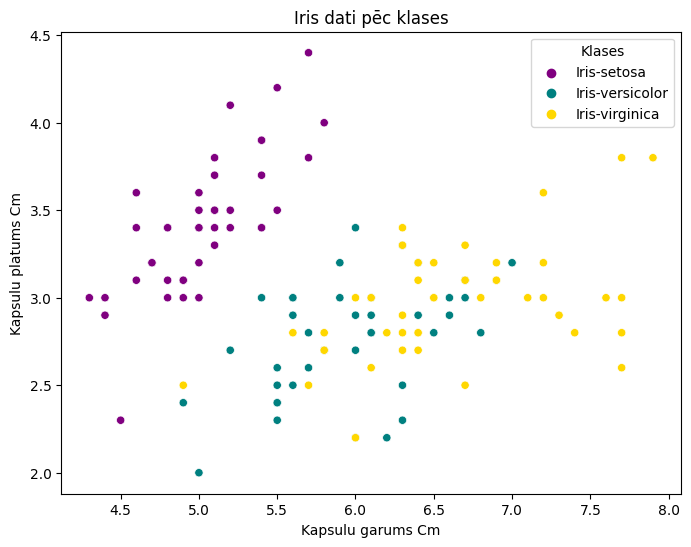

In [320]:
# Grafiskais attēlojums (Scatter plot)
# ================================
# Šeit ir izveidots grafiks: x = 'Lapu garums Cm', y = 'Lapu platums Cm', 
# atšķirot ziedu sugas ar dažādām krāsām.

def plot_iris_scatter(data_df):
    plt.figure(figsize=(8, 6)) #grafika izmērs
#Definējam punktu krāsu
    custom_palette = {
        "Iris-setosa": "purple",
        "Iris-versicolor": "teal",
        "Iris-virginica": "gold"
    }
    sns.scatterplot( #definējam x un y ass 
        data=data_df,
        x='Kapsulu garums Cm',
        y='Kapsulu platums Cm',
        hue='Suga',
        palette=custom_palette
    )
    plt.title("Iris dati pēc klases") #definējam grafikam nosaukumu un leģendu
    plt.legend(title="Klases")
    plt.show()

plot_iris_scatter(data_df)
# Izsaucam funkciju, lai uzzīmētu grafiku par jau ielādētajiem datiem
